Getting started using this brown dwarf metric notebook as a guide: https://github.com/yoachim/LSST-BD-Cadence/blob/main/bd_dist_metric.ipynb

In [1]:
from lsst.sims.maf.metrics.baseMetric import BaseMetric
import lsst.sims.maf.utils as mafUtils
import lsst.sims.utils as utils
from scipy import interpolate

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.units as u
from astropy.io import ascii, fits
import glob

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.maps as maps

/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/db/opsimDatabase.py:95: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupBy is 'default' and tableName==self.defaultTable:
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/db/opsimDatabase.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if groupBy is 'default' and tableName!=self.defaultTable:
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:127: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  (key is not 'bins') & (key is not 'binCol'):
/data0/lsst_stack/stack/miniconda3-py38_4.9.2-0.4.2/Linux64/sims_maf/2.13.0.sims-93-g8bc2eb33+a14e41332a/python/lsst/sims/maf/slicers/opsimFieldSlicer.py:127: SyntaxWarning: "is not" with a literal. Did yo

In [2]:
from mafContrib.lssmetrics import depthLimitedNumGalMetric
from mafContrib.LSSObsStrategy.galaxyCountsMetric_extended import GalaxyCountsMetric_extended \
    as GalaxyCountsMetric

Read in the Karachentsev catalog of Local Volume galaxies:

In [3]:
lv_dat0 = fits.getdata('lsst_galaxies_1p25to9Mpc_table.fits')

In [4]:
# Keep only galaxies at dec < 35 deg., and with stellar masses > 10^7 M_Sun.

lv_dat_cuts = (lv_dat0['dec'] < 35.0) & (lv_dat0['MStars'] > 1e7) & (lv_dat0['MStars'] < 1e14)
lv_dat = lv_dat0[lv_dat_cuts]

Make a list of all the OpSim databases by crawling the directories:

In [5]:
dblist = []
glob_dirs17 = glob.glob('/sims_maf/fbs_1.7/*')
for globdir in glob_dirs17:
    tmpglob = glob.glob(globdir+'/*.db')
    for dbname in tmpglob:
        dblist.append(dbname)
        
glob_dirs171 = glob.glob('/sims_maf/fbs_1.7.1/*')
for globdir in glob_dirs171:
    tmpglob = glob.glob(globdir+'/*.db')
    for dbname in tmpglob:
        dblist.append(dbname)
        
glob_dirs16 = glob.glob('/sims_maf/fbs_1.6/*')
for globdir in glob_dirs16:
    tmpglob = glob.glob(globdir+'/*.db')
    for dbname in tmpglob:
        dblist.append(dbname)

glob_dirs15 = glob.glob('/sims_maf/fbs_1.5/*')
for globdir in glob_dirs15:
    tmpglob = glob.glob(globdir+'/*.db')
    for dbname in tmpglob:
        dblist.append(dbname)

glob_dirs15sso = glob.glob('/sims_maf/fbs_1.5_sso/*')
for globdir in glob_dirs15sso:
    tmpglob = glob.glob(globdir+'/*.db')
    for dbname in tmpglob:
        dblist.append(dbname)

glob_dirs16sso = glob.glob('/sims_maf/fbs_1.6_sso/*')
for globdir in glob_dirs16sso:
    tmpglob = glob.glob(globdir+'/*.db')
    for dbname in tmpglob:
        dblist.append(dbname)


In [6]:
# dblist

In [7]:
'''
import os
import run_info as ri
families = ri.FamilyInfo()
allsims = []
for f in families.list_of_families():
    allsims += [s for s in families.family[f]]
allsims

families_we_want = ['visit_time', 'u_long', 'wfd_depth', 'footprint', 'footprint_tune', 'good_seeing']
oursims = []
for f in families_we_want:
    oursims += [s for s in families.family[f]]
oursims

rootdir = '/sims_maf/'
alldbs = glob.glob(os.path.join(rootdir, 'fbs_1.*', '*', '*10yrs.db'))
# alldbs.append(glob.glob(os.path.join(rootdir, 'fbs_1.*', '*visit_time*', '*10yrs.db')))
#alldbs.append(glob.glob(os.path.join(rootdir, 'fbs_1.*', '*baseline*', '*10yrs.db'))[0])
#alldbs.append(glob.glob(os.path.join(rootdir, 'fbs_1.*', '*wfd_depth*', '*10yrs.db'))[0])

#alldbs
dblist = [s for s in alldbs if os.path.split(s)[-1].replace('.db', '') in oursims]

dblist.append('/sims_maf/fbs_1.7/baseline/baseline_nexp1_v1.7_10yrs.db')
dblist
'''

"\nimport os\nimport run_info as ri\nfamilies = ri.FamilyInfo()\nallsims = []\nfor f in families.list_of_families():\n    allsims += [s for s in families.family[f]]\nallsims\n\nfamilies_we_want = ['visit_time', 'u_long', 'wfd_depth', 'footprint', 'footprint_tune', 'good_seeing']\noursims = []\nfor f in families_we_want:\n    oursims += [s for s in families.family[f]]\noursims\n\nrootdir = '/sims_maf/'\nalldbs = glob.glob(os.path.join(rootdir, 'fbs_1.*', '*', '*10yrs.db'))\n# alldbs.append(glob.glob(os.path.join(rootdir, 'fbs_1.*', '*visit_time*', '*10yrs.db')))\n#alldbs.append(glob.glob(os.path.join(rootdir, 'fbs_1.*', '*baseline*', '*10yrs.db'))[0])\n#alldbs.append(glob.glob(os.path.join(rootdir, 'fbs_1.*', '*wfd_depth*', '*10yrs.db'))[0])\n\n#alldbs\ndblist = [s for s in alldbs if os.path.split(s)[-1].replace('.db', '') in oursims]\n\ndblist.append('/sims_maf/fbs_1.7/baseline/baseline_nexp1_v1.7_10yrs.db')\ndblist\n"

In [8]:
# families.family['new_rolling']


In [9]:
# Set up some parameters to be used for all metric extraction:

nside = 16 # 64
sql = 'filter="g" or filter="i"'
sql_i = 'filter = "i"'
sql_g = 'filter = "g"'
sql_r = 'filter = "r"'

outDir='temp'
resultsDb = db.ResultsDb(outDir)

Now loop over all the OpSim databases, using predefined metrics to extract the info we will need. This includes:

- galaxy number counts
- stellar density, with various r-band limits
- coadd M5 in g, r, i

In [10]:
all_bg = []

for dbname in dblist:
    dbFile = dbname
    runName = dbFile.replace('.db', '')
    conn = db.OpsimDatabase(dbFile)
    # outDir='temp'
    # resultsDb = db.ResultsDb(outDir=outDir)
    bundleList = []
    
    slicer = slicers.UserPointsSlicer(lv_dat['ra'], lv_dat['dec'])
    plotDict = {}

    metric_ngal = GalaxyCountsMetric(nside=nside, metricName='numGal')
    bundleList.append(metricBundles.MetricBundle(metric_ngal, slicer, sql_i, plotDict=plotDict,
                                                 runName=runName))

    mafMap = maps.StellarDensityMap()
    #metric_nstar = metrics.StarDensityMetric(rmagLimit=26.865, metricName='nstars_rmag<medianM5')
    #bundleList.append(metricBundles.MetricBundle(metric_nstar,slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))

    metric_nstar24 = metrics.StarDensityMetric(rmagLimit=24, metricName='nstars_rmag<24')
    metric_nstar24p5 = metrics.StarDensityMetric(rmagLimit=24.5, metricName='nstars_rmag<24.5')
    metric_nstar25 = metrics.StarDensityMetric(rmagLimit=25, metricName='nstars_rmag<25')
    metric_nstar25p5 = metrics.StarDensityMetric(rmagLimit=25.5, metricName='nstars_rmag<25.5')
    metric_nstar26 = metrics.StarDensityMetric(rmagLimit=26, metricName='nstars_rmag<26')
    metric_nstar26p5 = metrics.StarDensityMetric(rmagLimit=26.5, metricName='nstars_rmag<26.5')
    metric_nstar27 = metrics.StarDensityMetric(rmagLimit=27, metricName='nstars_rmag<27')
    bundleList.append(metricBundles.MetricBundle(metric_nstar24, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_nstar24p5, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_nstar25, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_nstar25p5, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_nstar26, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_nstar26p5, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_nstar27, slicer, sql, mapsList=[mafMap], plotDict=plotDict, runName=runName))

    metric_coadd = metrics.Coaddm5Metric()
    bundleList.append(metricBundles.MetricBundle(metric_coadd, slicer, sql_i, plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_coadd, slicer, sql_g, plotDict=plotDict, runName=runName))
    bundleList.append(metricBundles.MetricBundle(metric_coadd, slicer, sql_r, plotDict=plotDict, runName=runName))
    
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()

    all_bg.append(bg)

Querying database SummaryAllProps with constraint filter = "r" for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA']
Found 489299 visits
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp1_v1_7_10yrs_CoaddM5_r_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="g" or filter="i" for columns ['fieldDec', 'fieldRA']
Found 713082 visits
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp1_v1_7_10yrs_nstars_rmaglt24_g_or_i_USER']
Completed metric generation.
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp1_v1_7_10yrs_nstars_rmaglt24_5_g_or_i_USER']
Completed metric generation.
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp1_v1_7_10yrs_nstars_rmaglt25_g_or_i_USER']
Completed metric generation.
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp1_v1_7_10yrs_nstars_rmaglt25_5_g_or_i_USER']
Completed metric generation.
Running:  ['_sims_maf_fbs_1_7_baseline_baseline_nexp1_v1_7

In [11]:
'''
#first: compute integrated mag in B:
LF = ascii.read('LF_-1.5_10Gyr_B.dat', header_start=12)
mags = LF['magbinc']
counts = LF['Bmag']
intBmag = -2.5*np.log10( np.sum(counts * np.power(10.0,-0.4*mags) ))
print ('intMag='+str(intBmag))
#result is 6.856379, store it for later
'''

# make fake LF for old galaxy of given integrated B, distance modulus mu, in any of filters ugrizY
def makeFakeLF(intB, mu, filtername): 
    if (filtername=='y'): filtername=='Y'
    modelBmag = 6.856379 # integrated B mag of the model LF being read
    LF = ascii.read('LF_-1.5_10Gyr.dat', header_start=12)
    mags = LF['magbinc']
    counts = LF[filtername+'mag']
    # shift model LF to requested distance and dim it
    mags = mags + mu
    modelBmag = modelBmag + mu
    # scale model counts up/down to reach the requested intB
    factor = np.power(10.0,-0.4*(intB-modelBmag))
    counts = factor * counts
    return mags, counts
    
#test: now will make a fake LF for 47Tuc, with intB=5.78, mu0=13.32
#intB=5.78
#mu0=13.32
#LFmags,LFcounts = makeFakeLF(intB,mu0,'r')
#for i in range(len(LFmags)):
#    print (LFmags[i],LFcounts[i])


Create a dictionary of luminosity functions to use as a look-up table.

(Use distance modulus = 0 -- we will apply the distance modulus later.)

In [12]:
lf_dict_i = {}
lf_dict_g = {}
tmp_MB = -10.0

for i in range(101):
    mbkey = f'MB{tmp_MB:.2f}'
    iLFmags,iLFcounts = makeFakeLF(tmp_MB, 0.0, 'i')
    lf_dict_i[mbkey] = (np.array(iLFmags), np.array(iLFcounts))
    gLFmags,gLFcounts = makeFakeLF(tmp_MB, 0.0, 'g')
    lf_dict_g[mbkey] = (np.array(gLFmags), np.array(gLFcounts))
    tmp_MB += 0.1

Create a function that estimates the surface brightness limit based on the following inputs:

- g and i-band M5 limits
- number of stars required for detection, based on a required Poisson S/N factoring in background galaxies and foreground stars
- the distance at which you'd like to detect the dwarf

In [13]:
def sum_luminosity(LFmags, LFcounts):
    magref = LFmags[0]
    totlum = 0.0
    
    for mag, count in zip(LFmags, LFcounts):
        tmpmags = np.repeat(mag, count)
        totlum += np.sum(10.0**((magref - tmpmags)/2.5))

    mtot = magref-2.5*np.log10(totlum)
    return mtot
    
def sblimit(mags_g, mags_i, nstars_req, distlim):
    distance_limit = distlim*1e6 # distance limit in parsecs
    distmod_limit = 5.0*np.log10(distance_limit) - 5.0

    mg_lim = []
    mi_lim = []
    sbg_lim = []
    sbi_lim = []
    flag_lim = []
    
    for glim, ilim, nstars, distmod_lim in zip(mags_g, mags_i, nstars_req, distmod_limit):
    # for i in range(len(mags_g)):
        if (glim > 15) and (ilim > 15):
            # print(glim, ilim, nstars)
            fake_MB = -10.0
            ng = 1e6
            ni = 1e6
    
            while (ng > nstars) and (ni > nstars) and fake_MB<-2.0:
                # B_fake = distmod_limit+fake_MB
                mbkey = f'MB{fake_MB:.2f}'
                iLFmags0,iLFcounts0 = lf_dict_i[mbkey]
                gLFmags0,gLFcounts0 = lf_dict_g[mbkey]
                iLFcounts = np.random.poisson(iLFcounts0)
                gLFcounts = np.random.poisson(gLFcounts0)
                iLFmags = iLFmags0+distmod_lim # Add the distance modulus to make it apparent mags
                gLFmags = gLFmags0+distmod_lim # Add the distance modulus to make it apparent mags
                # print(iLFcounts0-iLFcounts)
                gsel = (gLFmags <= glim)
                isel = (iLFmags <= ilim)
                ng = np.sum(gLFcounts[gsel])
                ni = np.sum(iLFcounts[isel])
                # print('fake_MB: ',fake_MB, ' ng: ',ng, ' ni: ', ni, ' nstars: ', nstars)
                fake_MB += 0.1
            
            if fake_MB > -9.9:
                gmag_tot = sum_luminosity(gLFmags[gsel], gLFcounts[gsel]) - distmod_lim
                imag_tot = sum_luminosity(iLFmags[isel], iLFcounts[isel]) - distmod_lim
                # S = m + 2.5logA, where in this case things are in sq. arcmin, so A = 1 arcmin^2 = 3600 arcsec^2
                sbtot_g = distmod_lim + gmag_tot + 2.5*np.log10(3600.0)
                sbtot_i = distmod_lim + imag_tot + 2.5*np.log10(3600.0)
                mg_lim.append(gmag_tot)
                mi_lim.append(imag_tot)
                sbg_lim.append(sbtot_g)
                sbi_lim.append(sbtot_i)
                if (ng < ni):
                    flag_lim.append('g')
                else:
                    flag_lim.append('i')
            else:
                mg_lim.append(999.9)
                mi_lim.append(999.9)
                sbg_lim.append(999.9)
                sbi_lim.append(999.9)
                flag_lim.append('none')
        else:
            mg_lim.append(999.9)
            mi_lim.append(999.9)
            sbg_lim.append(-999.9)
            sbi_lim.append(-999.9)
            flag_lim.append('none')
        
    return mg_lim, mi_lim, sbg_lim, sbi_lim, flag_lim


In [14]:
# Calculate the factor to go from number per healpix to number per square arcminute or per square arcsec
pixarea_deg = hp.nside2pixarea(nside, degrees=True)*(u.degree**2)
pixarea_arcmin = pixarea_deg.to(u.arcmin**2)
pixarea_arcsec = pixarea_deg.to(u.arcsec**2)

# Account for:
#  - cmd_frac: fraction of CMD area being selected
#  - stargal_contamination: what fraction of objects in your "star" selection after star-galaxy separation are background galaxy contaminants?

cmd_frac = 0.1
stargal_contamination = 0.40
nsigma = 10.0


In [15]:
names = []
mg_lims = []
mi_lims = []
mv_lims = []
sb_g_lims = []
sb_i_lims = []
sb_v_lims = []
nbelow_mv_7 = []

loadsaved = False

for ind in range(len(dblist)):
    run = dblist[ind]
    runName = run.replace('.db', '')
    root0 = str.replace(runName, '/', '_')
    root = str.replace(root0, '.', '_')

    if loadsaved:
       
        i5 = np.load('temp/'+root+'_CoaddM5_i_USER.npz')['metricValues']
        g5 = np.load('temp/'+root+'_CoaddM5_g_USER.npz')['metricValues']
        r5 = np.load('temp/'+root+'_CoaddM5_r_USER.npz')['metricValues']
        ngal = np.load('temp/'+root+'_numGal_i_USER.npz')['metricValues']
        # Just use the r<27 values for the "total" number of stars:
        nstar = np.load('temp/'+root+'_nstars_rmaglt27_g_or_i_USER.npz')['metricValues']
        nstar_r24 = np.load('temp/'+root+'_nstars_rmaglt24_g_or_i_USER.npz')['metricValues']
        nstar_r24p5 = np.load('temp/'+root+'_nstars_rmaglt24_5_g_or_i_USER.npz')['metricValues']
        nstar_r25 = np.load('temp/'+root+'_nstars_rmaglt25_g_or_i_USER.npz')['metricValues']
        nstar_r25p5 = np.load('temp/'+root+'_nstars_rmaglt25_5_g_or_i_USER.npz')['metricValues']
        nstar_r26 = np.load('temp/'+root+'_nstars_rmaglt26_g_or_i_USER.npz')['metricValues']
        nstar_r26p5 = np.load('temp/'+root+'_nstars_rmaglt26_5_g_or_i_USER.npz')['metricValues']
        nstar_r27 = np.load('temp/'+root+'_nstars_rmaglt27_g_or_i_USER.npz')['metricValues']

    else:
        bg = all_bg[ind]

        i5 = bg.bundleDict[root+'_CoaddM5_i_USER'].metricValues
        g5 = bg.bundleDict[root+'_CoaddM5_g_USER'].metricValues
        r5 = bg.bundleDict[root+'_CoaddM5_r_USER'].metricValues

        ngal = bg.bundleDict[root+'_numGal_i_USER'].metricValues
        # nstar = bg.bundleDict[root+'_nstars_rmagltmedianM5_g_or_i_USER'].metricValues
        # Just use the r<27 values for the "total" number of stars:
        nstar = bg.bundleDict[root+'_nstars_rmaglt27_g_or_i_USER'].metricValues

        nstar_r24 = bg.bundleDict[root+'_nstars_rmaglt24_g_or_i_USER'].metricValues
        nstar_r24p5 = bg.bundleDict[root+'_nstars_rmaglt24_5_g_or_i_USER'].metricValues
        nstar_r25 = bg.bundleDict[root+'_nstars_rmaglt25_g_or_i_USER'].metricValues
        nstar_r25p5 = bg.bundleDict[root+'_nstars_rmaglt25_5_g_or_i_USER'].metricValues
        nstar_r26 = bg.bundleDict[root+'_nstars_rmaglt26_g_or_i_USER'].metricValues
        nstar_r26p5 = bg.bundleDict[root+'_nstars_rmaglt26_5_g_or_i_USER'].metricValues
        nstar_r27 = bg.bundleDict[root+'_nstars_rmaglt27_g_or_i_USER'].metricValues

    nstar_all = nstar*0.0
    rbinvals = np.arange(24.0, 27.5, 0.5)
    rbinnames = [nstar_r24, nstar_r24p5, nstar_r25, nstar_r25p5, nstar_r26, nstar_r26p5, nstar_r27]

    for binval,bindensity in zip(rbinvals, rbinnames):
        inbin = np.where(np.abs(r5-binval) < 0.25)
        nstar_all[inbin] = bindensity[inbin]

    outside_faint = (r5 >= 27.25)
    outside_bright = (r5 <= 23.75)
    nstar_all[outside_faint] = nstar[outside_faint]
    nstar_all[outside_bright] = nstar_r24[outside_bright]

    # Star density is number of stars per square arcsec. Convert to a total number per healpix, then number per sq. arcmin:
    nstar_all_per_healpix = nstar_all*pixarea_arcsec.value
    nstar_all_per_arcmin = nstar_all_per_healpix/pixarea_arcmin.value
    
    # Number of galaxies is the total in each healpix. Convert to number per sq. arcmin:
    ngal_per_arcmin = ngal/pixarea_arcmin.value

    # Star density is number of stars per square arcsec. Convert to a total number per healpix, then number per sq. arcmin:
    nstar_per_healpix = nstar*pixarea_arcsec.value
    nstar_per_arcmin = nstar_per_healpix/pixarea_arcmin.value
    
    nstars_required = nsigma*np.sqrt(ngal_per_arcmin*(cmd_frac*stargal_contamination)+(nstar_all_per_arcmin*cmd_frac))

    mg_lim, mi_lim, sb_g_lim, sb_i_lim, flag_lim = sblimit(g5, i5, nstars_required, distlim=lv_dat['dist_Mpc'])

    names.append(run)
    mg_lims.append(mg_lim)
    mi_lims.append(mi_lim)
    sb_g_lims.append(sb_g_lim)
    sb_i_lims.append(sb_i_lim)
    

<ipython-input-15-8c9c42e16168>:78: RuntimeWarning: invalid value encountered in sqrt
  nstars_required = nsigma*np.sqrt(ngal_per_arcmin*(cmd_frac*stargal_contamination)+(nstar_all_per_arcmin*cmd_frac))


In [16]:
'''
run = dblist[0]
runName = run.replace('.db', '')
root0 = str.replace(runName, '/', '_')
root = str.replace(root0, '.', '_')
print(root)

all_bg[1].bundleDict[root+'_CoaddM5_i_USER'].metricValues
'''

"\nrun = dblist[0]\nrunName = run.replace('.db', '')\nroot0 = str.replace(runName, '/', '_')\nroot = str.replace(root0, '.', '_')\nprint(root)\n\nall_bg[1].bundleDict[root+'_CoaddM5_i_USER'].metricValues\n"

In [17]:
mg_medians = []
mi_medians = []
mv_medians = []
sbg_medians = []
sbi_medians = []
sbv_medians = []
nbelow_mv7 = []
maxdist = []
tot_mstar = []
ind_below_mv7 = []

for mg, mi, sbg, sbi in zip(mg_lims, mi_lims, sb_g_lims, sb_i_lims):
    mg = np.array(mg)
    mi = np.array(mi)
    sbg = np.array(sbg)
    sbi = np.array(sbi)

    okgx = (np.abs(sbi) < 90) & (np.abs(sbg) < 90) & (np.abs(mi) < 90) & (np.abs(mg) < 90)

    # okmg = (np.abs(mg) < 90)
    # print(np.median(mg[okmg]))
    
    # Use the conversion from Appendix A of Komiyama+2018, ApJ, 853, 29:
    # V = g_hsc - 0.371*(gi_hsc)-0.068
    mv = mg-0.371*(mg-mi)-0.068
    sbv = sbg-0.371*(sbg-sbi)-0.068
    
    mg_medians.append(np.median(mg[okgx]))
    mi_medians.append(np.median(mi[okgx]))
    mv_medians.append(np.median(mv[okgx]))
    sbg_medians.append(np.median(sbg[okgx]))
    sbi_medians.append(np.median(sbi[okgx]))
    sbv_medians.append(np.median(sbv[okgx]))
    maxdist.append(np.max(lv_dat[okgx]['Dist_Mpc']))
    tot_mstar.append(np.sum(lv_dat[okgx]['MStars']))
    ok_below_mv7 = (mv > -7) & (mv < 0)
    nbelow_mv7.append(len(lv_dat[ok_below_mv7]))
    # nbelow_mv7.append(len(lv_dat[(mv > -7) & (mv < 0)]))
    ind_below_mv7.append(ok_below_mv7)

#print(len(lv_dat), len(lv_dat[(mv > -7) & (mv < 0)]))

In [18]:
# Select the "fiducial" visit(s) to be the baseline (nexp2 and nexp1):
name_arr = np.array(names)

fiducial2 = np.where(name_arr == '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db')
fiducial1 = np.where(name_arr == '/sims_maf/fbs_1.7/baseline/baseline_nexp1_v1.7_10yrs.db')

In [19]:
aaa = np.array(ind_below_mv7)
np.shape(aaa[0][:])

(302,)

In [20]:
# lv_dat[ind_below_mv7[0]]

arr_ind_below_mv7 = np.array(ind_below_mv7)
success_frac = np.sum(arr_ind_below_mv7, axis=0)/np.shape(arr_ind_below_mv7)[0]    

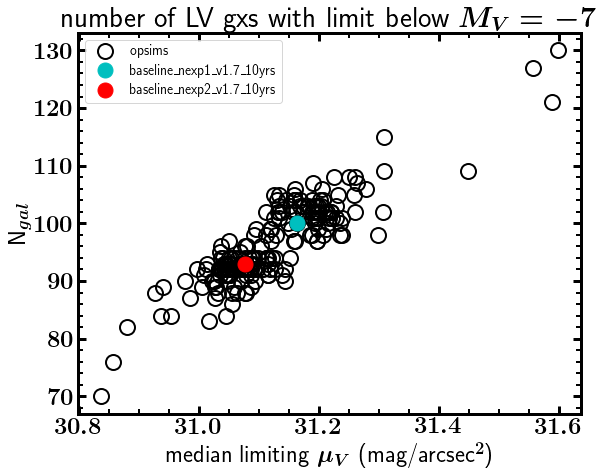

In [36]:
params = {
   'axes.labelsize': 24,
   'font.size': 24,
   'legend.fontsize': 14,
#   'xtick.labelsize': 16,
   'xtick.major.width': 3,
   'xtick.minor.width': 2,
   'xtick.major.size': 8,
   'xtick.minor.size': 5,
   'xtick.direction': 'in',
   'xtick.top': True,
   'lines.linewidth':3,
   'axes.linewidth':3,
   'axes.labelweight':3,
   'axes.titleweight':3,
   'ytick.major.width':3,
   'ytick.minor.width':2,
   'ytick.major.size': 8,
   'ytick.minor.size': 5,
   'ytick.direction': 'in',
   'ytick.right': True,
#   'ytick.labelsize': 20,
   'text.usetex': True,
   'text.latex.preamble': r'\boldmath',
   'figure.figsize': [9, 7],
   'figure.facecolor': 'White'
   }

plt.rcParams.update(params)

#plt.plot(nbelow_mv7, 'k.')
#plt.plot(nbelow_mv7, 'k')
#plt.plot(mv_medians, nbelow_mv7, 'k.')
#plt.scatter(sbv_medians, nbelow_mv7, c=np.array(tot_mstar)/1e11, s=75, label='opsims', cmap='bone_r', vmin=3.0)
plt.plot(sbv_medians, nbelow_mv7, 'ko', ms=15, fillstyle='none', markeredgewidth=2, label='opsims')
plt.plot(sbv_medians[fiducial1[0][0]], nbelow_mv7[fiducial1[0][0]], 'co', ms=15, label='baseline\_nexp1\_v1.7\_10yrs')
plt.plot(sbv_medians[fiducial2[0][0]], nbelow_mv7[fiducial2[0][0]], 'ro', ms=15, label='baseline\_nexp2\_v1.7\_10yrs')
plt.legend()
#plt.colorbar(label='total $M_* (10^{11} M_{Sun})$, all galaxies')
plt.xlabel('median limiting $\mu_V$ (mag/arcsec$^2$)')
plt.ylabel('N$_{gal}$')
plt.title('number of LV gxs with limit below $M_V = -7$')
plt.minorticks_on()
# plt.savefig('ngal_below_mv_minus7_vs_sblimit_mstar_color.png')
# plt.savefig('ngal_below_mv_minus7_vs_sblimit_all200sims.png')
plt.show()

In [22]:
aaa = (lv_dat['MStars'] > 1e14)
print(lv_dat[aaa])

[]


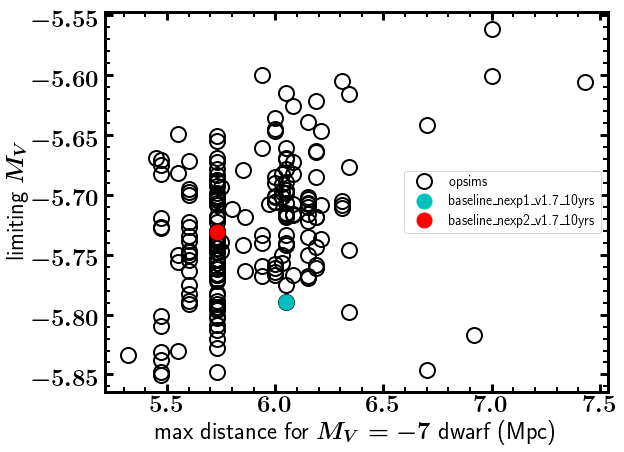

In [23]:
plt.plot(maxdist, mv_medians, 'ko', ms=15, fillstyle='none', markeredgewidth=2, label='opsims')
plt.plot(maxdist[fiducial1[0][0]], mv_medians[fiducial1[0][0]], 'co', ms=15, label='baseline\_nexp1\_v1.7\_10yrs')
plt.plot(maxdist[fiducial2[0][0]], mv_medians[fiducial2[0][0]], 'ro', ms=15, label='baseline\_nexp2\_v1.7\_10yrs')
plt.legend()
plt.xlabel('max distance for $M_V = -7$ dwarf (Mpc)')
plt.ylabel('limiting $M_V$')
plt.minorticks_on()
# plt.savefig('maxdist_mv_minus7_vs_median_M_V.png')
plt.show()

In [24]:
names

['/sims_maf/fbs_1.7/baseline/baseline_nexp1_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.00_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.05_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.10_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.30_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.70_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither1.00_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither1.50_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/ddf_dither/ddf_dither2.00_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither1_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither2_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither3_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither4_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/euclid_dither/euclid_dither5_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/footprint_tune/footprint_0_v1.710yrs.db

In [25]:
bad_AB = (lv_dat['AB'] > 1.0)

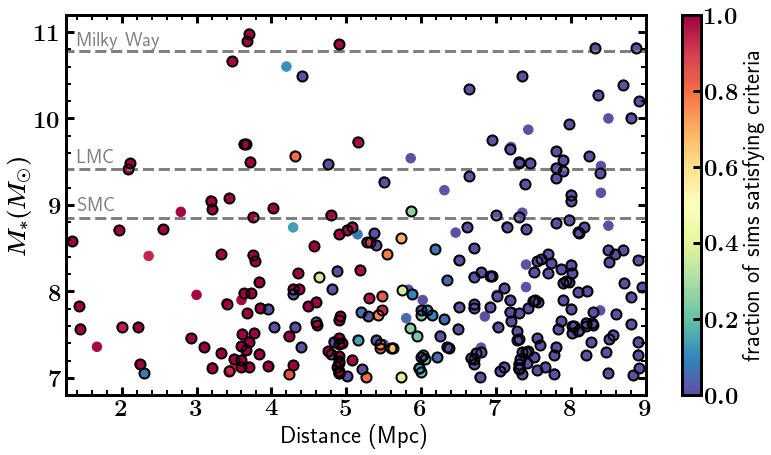

In [37]:
params = {
   'axes.labelsize': 24,
   'font.size': 24,
   'legend.fontsize': 14,
#   'xtick.labelsize': 16,
   'xtick.major.width': 3,
   'xtick.minor.width': 2,
   'xtick.major.size': 8,
   'xtick.minor.size': 5,
   'xtick.direction': 'in',
   'xtick.top': True,
   'lines.linewidth':3,
   'axes.linewidth':3,
   'axes.labelweight':3,
   'axes.titleweight':3,
   'ytick.major.width':3,
   'ytick.minor.width':2,
   'ytick.major.size': 8,
   'ytick.minor.size': 5,
   'ytick.direction': 'in',
   'ytick.right': True,
#   'ytick.labelsize': 20,
   'text.usetex': True,
   'text.latex.preamble': r'\boldmath',
   'figure.figsize': [13, 7],
   'figure.facecolor': 'White'
   }

plt.rcParams.update(params)

plt.hlines(np.log10(6.025e10), 1, 10, linestyle='--', color='Gray')
plt.text(1.4, 10.8, 'Milky Way',color='Gray',size=20,horizontalalignment='left',verticalalignment='bottom')
plt.hlines(np.log10(2.63e9), 1, 10, linestyle='--', color='Gray')
plt.text(1.4, 9.45, 'LMC',color='Gray',size=20,horizontalalignment='left',verticalalignment='bottom')
plt.hlines(np.log10(7.08e8), 1, 10, linestyle='--', color='Gray')
plt.text(1.4, 8.9, 'SMC',color='Gray',size=20,horizontalalignment='left',verticalalignment='bottom')
# plt.scatter(lv_dat['Dist_Mpc'], np.log10(lv_dat['MStars']), c=lv_dat['AB'], cmap='Spectral_r', s=90, vmax=0.5)
# plt.scatter(lv_dat[~bad_AB]['Dist_Mpc'], np.log10(lv_dat[~bad_AB]['MStars']), c=success_frac[~bad_AB], cmap='Spectral_r', s=90)
plt.scatter(lv_dat['Dist_Mpc'], np.log10(lv_dat['MStars']), c=success_frac, cmap='Spectral_r', s=90)
plt.plot(lv_dat[~bad_AB]['Dist_Mpc'], np.log10(lv_dat[~bad_AB]['MStars']), 'ko', fillstyle='none', ms=10, markeredgewidth=2)
plt.colorbar(label='fraction of sims satisfying criteria')
plt.xlabel('Distance (Mpc)')
plt.ylabel('$M_* (M_\odot)$')
plt.xlim(1.25, 9)
plt.ylim(6.8, 11.2)
plt.minorticks_on()
# plt.savefig('mstar_vs_dist_frac_OK.png')
# plt.savefig('mstar_vs_dist_frac_OK_all200sims.png')
plt.show()

In [38]:
from astropy.table import Table

tab = Table([names, mv_medians, sbv_medians, nbelow_mv7, maxdist], names=['sim', 'mv_lim', 'sbv_lim', 'nbelow_mv7', 'maxdist_mv7'])

In [28]:
tab[0:20]

sim,mv_lim,sbv_lim,nbelow_mv7,maxdist_mv7
str91,float64,float64,int64,float64
/sims_maf/fbs_1.7/baseline/baseline_nexp1_v1.7_10yrs.db,-5.78921889041862,31.16387863141872,100,6.05
/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db,-5.731080616444355,31.07634726453095,93,5.73
/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.00_v1.7_10yrs.db,-5.722418111090903,31.075126009001245,92,5.6
/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.05_v1.7_10yrs.db,-5.759191012502958,31.07760655258783,96,5.94
/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.10_v1.7_10yrs.db,-5.766802360762357,31.103051117027462,96,6.0
/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.30_v1.7_10yrs.db,-5.701682944317094,31.10670061549857,92,5.73
/sims_maf/fbs_1.7/ddf_dither/ddf_dither0.70_v1.7_10yrs.db,-5.762003562031488,31.076845680421894,92,5.73
/sims_maf/fbs_1.7/ddf_dither/ddf_dither1.00_v1.7_10yrs.db,-5.77053221600366,31.00768303510068,91,5.73
/sims_maf/fbs_1.7/ddf_dither/ddf_dither1.50_v1.7_10yrs.db,-5.73845120653594,31.044972684270412,92,5.73


In [40]:
tab.write('lvgx_sims_compare_all200sims.fits')

In [30]:
from astropy.coordinates import SkyCoord

sc_dat = SkyCoord(ra=lv_dat['ra']*u.deg, dec=lv_dat['dec']*u.deg)

In [1]:
#len(lv_dat)
lv_dat.columns

NameError: name 'lv_dat' is not defined

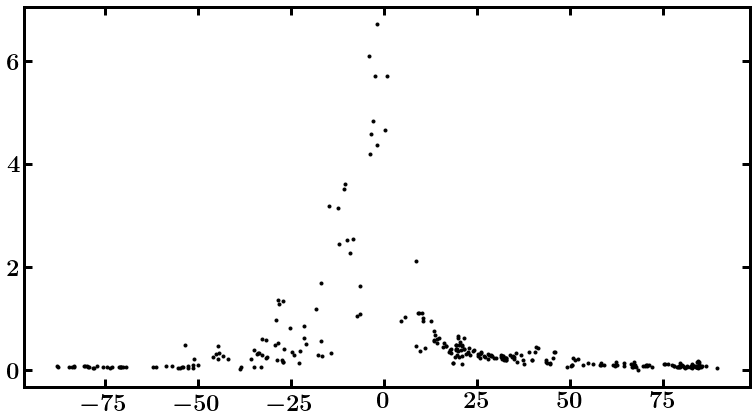

In [32]:
#plt.hist(lv_dat['AB'], np.arange(0, 3, 0.05))
plt.plot(sc_dat.galactic.b.value, lv_dat['AB'], 'k.')
plt.show()

In [33]:
d_gt_6 = (lv_dat['Dist_Mpc'] > 6.0)
print(len(lv_dat[d_gt_6]), len(lv_dat[~d_gt_6]))

163 139


In [34]:

run = dblist[0]
runName = run.replace('.db', '')
root0 = str.replace(runName, '/', '_')
root = str.replace(root0, '.', '_')

i5 = np.load('temp/'+root+'_CoaddM5_i_USER.npz')['metricValues']


In [35]:
i5

array([2.64122022e+001, 2.63827391e+001, 2.63464352e+001, 2.64035912e+001,
       2.64804793e+001, 2.64561595e+001, 2.57203022e+001, 2.64357740e+001,
       2.64486944e+001, 2.64387990e+001, 2.64287630e+001, 2.64392294e+001,
       2.64726386e+001, 2.64440841e+001, 2.56230163e+001, 2.64319168e+001,
       2.57573818e+001, 2.55852914e+001, 2.64774268e+001, 4.91506386e-319,
       2.57063579e+001, 0.00000000e+000, 2.64986071e+001, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       3.22782968e-319, 0.00000000e+000, 2.53639089e+001, 2.63313546e+001,
       2.48049008e+001, 2.64140545e+001, 2.64591309e+001, 2.53967505e+001,
       2.54418463e+001, 1.51016105e-319, 2.65327684e+001, 2.55421984e+001,
       2.64225222e+001, 2.56769251e+001, 2.54718163e+001, 2.56942497e+001,
       2.64643291e+001, 2.65323557e+001, 2.56275253e+001, 2.64570055e+001,
       2.65080307e+001, 2.65700441e+001, 2.64167384e+001, 2.64636541e+001,
       2.61966318e+001, 2